In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy
from re import findall

This notebook develops an ODE solver that follows the evolution of the nine species of $\rm{H}$, $\rm{H^+}$, $\rm{H^-}$, $\rm{He}$, $\rm{He^+}$, $\rm{He^{++}}$, $\rm{H_2}$, $\rm{H_2^+}$ and $\rm{e^-}$. The nine species network include the following reactions ([arXiv:1610.09591](https://arxiv.org/abs/1610.09591)):
- ${\rm H + e^{-}} \rightarrow \rm{H^{+} + e^{-} + e^{-}}$
- ${\rm H^{+} + e^{-}} \rightarrow \rm{H + \gamma} $
- ${\rm He + e^{-}} \rightarrow {\rm He^{+} + e^{-} + e^{-}}$
- ${\rm He^{+} + e^{-}} \rightarrow {\rm He + \gamma}$
- ${\rm He^{+} + e^{-}} \rightarrow {\rm He^{++} + e^{-} + e^{-}}$
- ${\rm He^{++} + e^{-}} \rightarrow {\rm He^{+} + \gamma}$
- ${\rm H + H} \rightarrow {\rm H^{+} + e^{-} + H}$
- ${\rm H + He} \rightarrow {\rm H^{+} + e^{-} + He}$
- ${\rm H + \gamma} \rightarrow {\rm H^{+} + e^{-}}$
- ${\rm He + \gamma} \rightarrow {\rm He^{+} + e^{-}}$
- ${\rm He^{+} + \gamma} \rightarrow {\rm He^{++} + e^{-}}$
- ${\rm H + e^{-}} \rightarrow {\rm H^{-} + \gamma}$
- ${\rm H^{-} + H} \rightarrow {\rm H_{2} + e^{-}}$
- ${\rm H + H^{+}} \rightarrow {\rm H_{2}^{+} + \gamma}$
- ${\rm H_{2}^{+} + H} \rightarrow {\rm H_{2} + H^{+}}$
- ${\rm H_{2} + H^{+}} \rightarrow {\rm H_{2}^{+} + H}$
- ${\rm H_{2} + e^{-}} \rightarrow {\rm H + H + e^{-}}$
- ${\rm H_{2} + H} \rightarrow {\rm H + H + H}$
- ${\rm H^{-} + e^{-}} \rightarrow {\rm H + e^{-} + e^{-}}$
- ${\rm H^{-} + H} \rightarrow {\rm H + e^{-} + H}$
- ${\rm H^{-} + H^{+}} \rightarrow {\rm H + H}$
- ${\rm H^{-} + H^{+}} \rightarrow {\rm H_{2}^{+} + e^{-}}$
- ${\rm H_{2}^{+} + e^{-}} \rightarrow {\rm H + H}$
- ${\rm H_{2}^{+} + H^{-}} \rightarrow {\rm H_{2} + H}$
- ${\rm H + H + H} \rightarrow {\rm H_{2} + H}$
- ${\rm H + H + H_{2}} \rightarrow {\rm H_{2} + H_{2}}$
- ${\rm H^{-} + \gamma} \rightarrow {\rm H + e^{-}}$
- ${\rm H_{2}^{+} + \gamma} \rightarrow {\rm H + H^{+}}$
- ${\rm H_{2} + \gamma} \rightarrow {\rm H_{2}^{+} + e^{-}}$
- ${\rm H_{2}^{+} + \gamma} \rightarrow {\rm H^{+} + H^{+} + e^{-}}$
- ${\rm H_{2} + \gamma} \rightarrow {\rm H + H}$
- ${\rm H + H + grain} \rightarrow {\rm H_{2} + grain}$

In [2]:
all_species = sympy.sympify(
    'HI, HII, HM, HeI, HeII, HeIII, H2I, H2II, de, gma, grn'
)

HI, HII, HM, HeI, HeII, HeIII, H2I, H2II, de, gma, grn = all_species

ks = sympy.sympify(
    'k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, ' \
    'k13, k14, k15, k16, k17, k18, k19, k20, k21, k22, k23, k24, ' \
    'k25, k26, k27, k28, k29, k30, k31, k32'
)

Generate equations from the paper's $\LaTeX$ source:

In [3]:
source = r'''- ${\rm H + e^{-}} \rightarrow {\rm H^{+} + e^{-} + e^{-}}$
                 - ${\rm H^{+} + e^{-}} \rightarrow {\rm H + \gamma}$
                 - ${\rm He + e^{-}} \rightarrow {\rm He^{+} + e^{-} + e^{-}}$
                 - ${\rm He^{+} + e^{-}} \rightarrow {\rm He + \gamma}$
                 - ${\rm He^{+} + e^{-}} \rightarrow {\rm He^{++} + e^{-} + e^{-}}$
                 - ${\rm He^{++} + e^{-}} \rightarrow {\rm He^{+} + \gamma}$
                 - ${\rm H + H} \rightarrow {\rm H^{+} + e^{-} + H}$
                 - ${\rm H + He} \rightarrow {\rm H^{+} + e^{-} + He}$
                 - ${\rm H + \gamma} \rightarrow {\rm H^{+} + e^{-}}$
                 - ${\rm He + \gamma} \rightarrow {\rm He^{+} + e^{-}}$
                 - ${\rm He^{+} + \gamma} \rightarrow {\rm He^{++} + e^{-}}$
                 - ${\rm H + e^{-}} \rightarrow {\rm H^{-} + \gamma}$
                 - ${\rm H^{-} + H} \rightarrow {\rm H_{2} + e^{-}}$
                 - ${\rm H + H^{+}} \rightarrow {\rm H_{2}^{+} + \gamma}$
                 - ${\rm H_{2}^{+} + H} \rightarrow {\rm H_{2} + H^{+}}$
                 - ${\rm H_{2} + H^{+}} \rightarrow {\rm H_{2}^{+} + H}$
                 - ${\rm H_{2} + e^{-}} \rightarrow {\rm H + H + e^{-}}$
                 - ${\rm H_{2} + H} \rightarrow {\rm H + H + H}$
                 - ${\rm H^{-} + e^{-}} \rightarrow {\rm H + e^{-} + e^{-}}$
                 - ${\rm H^{-} + H} \rightarrow {\rm H + e^{-} + H}$
                 - ${\rm H^{-} + H^{+}} \rightarrow {\rm H + H}$
                 - ${\rm H^{-} + H^{+}} \rightarrow {\rm H_{2}^{+} + e^{-}}$
                 - ${\rm H_{2}^{+} + e^{-}} \rightarrow {\rm H + H}$
                 - ${\rm H_{2}^{+} + H^{-}} \rightarrow {\rm H_{2} + H}$
                 - ${\rm H + H + H} \rightarrow {\rm H_{2} + H}$
                 - ${\rm H + H + H_{2}} \rightarrow {\rm H_{2} + H_{2}}$
                 - ${\rm H^{-} + \gamma} \rightarrow {\rm H + e^{-}}$
                 - ${\rm H_{2}^{+} + \gamma} \rightarrow {\rm H + H^{+}}$
                 - ${\rm H_{2} + \gamma} \rightarrow {\rm H_{2}^{+} + e^{-}}$
                 - ${\rm H_{2}^{+} + \gamma} \rightarrow {\rm H^{+} + H^{+} + e^{-}}$
                 - ${\rm H_{2} + \gamma} \rightarrow {\rm H + H}$
                 - ${\rm H + H + grain} \rightarrow {\rm H_{2} + grain}$'''

formulas = findall(r'\${\\rm (.*)} \\rightarrow {\\rm (.*)}\$', 
                   source.replace('H}', 'H }').replace('He}', 'He }'))

replace_rules = [#('e^{-}', 'de'), ('^{+}', 'p'), ('^{++}', 'pp'), ('^{-}', 'm'), 
                 #('_{2}', '2'), ('\\gamma', 'gma'), ('grain', 'grn'),
                 ('H^{-}', 'HM'), ('H^{+}', 'HII'), 
                 ('H_{2}^{+}', 'H2II'), ('H_{2}', 'H2I'), ('H ', 'HI '), 
                 ('He^{++}', 'HeIII'), ('He^{+}', 'HeII'), ('He ', 'HeI '), 
                 ('e^{-}', 'de'), ('\\gamma', 'gma'), ('grain', 'grn')]

formulas_clean = []
for i in range(len(formulas)):
    lhs, rhs = formulas[i]
    for latex, plain in replace_rules:
        lhs = lhs.replace(latex, plain)
        rhs = rhs.replace(latex, plain)
    print(lhs)
    formulas_clean.append((lhs, rhs))

all_reactions = [
    eval('({lhs}), ({rhs}), ks[{i}]'.format(lhs=lhs, rhs=rhs, i=i))
    for i, (lhs, rhs) in enumerate(formulas_clean)
]

HI + de
HII + de
HeI + de
HeII + de
HeII + de
HeIII + de
HI + HI 
HI + HeI 
HI + gma
HeI + gma
HeII + gma
HI + de
HM + HI 
HI + HII
H2II + HI 
H2I + HII
H2I + de
H2I + HI 
HM + de
HM + HI 
HM + HII
HM + HII
H2II + de
H2II + HM
HI + HI + HI 
HI + HI + H2I
HM + gma
H2II + gma
H2I + gma
H2II + gma
H2I + gma
HI + HI + grn


In [6]:
cmds = [
    '({lhs}), ({rhs}), k{i}'.format(lhs=lhs, rhs=rhs, i=i + 1)
    for i, (lhs, rhs) in enumerate(formulas_clean)
]
for cmd in cmds:
    print('(%s),' % cmd)

((HI + de), (HII + de + de), k1),
((HII + de), (HI + gma), k2),
((HeI + de), (HeII + de + de), k3),
((HeII + de), (HeI + gma), k4),
((HeII + de), (HeIII + de + de), k5),
((HeIII + de), (HeII + gma), k6),
((HI + HI ), (HII + de + HI ), k7),
((HI + HeI ), (HII + de + HeI ), k8),
((HI + gma), (HII + de), k9),
((HeI + gma), (HeII + de), k10),
((HeII + gma), (HeIII + de), k11),
((HI + de), (HM + gma), k12),
((HM + HI ), (H2I + de), k13),
((HI + HII), (H2II + gma), k14),
((H2II + HI ), (H2I + HII), k15),
((H2I + HII), (H2II + HI ), k16),
((H2I + de), (HI + HI + de), k17),
((H2I + HI ), (HI + HI + HI ), k18),
((HM + de), (HI + de + de), k19),
((HM + HI ), (HI + de + HI ), k20),
((HM + HII), (HI + HI ), k21),
((HM + HII), (H2II + de), k22),
((H2II + de), (HI + HI ), k23),
((H2II + HM), (H2I + HI ), k24),
((HI + HI + HI ), (H2I + HI ), k25),
((HI + HI + H2I), (H2I + H2I), k26),
((HM + gma), (HI + de), k27),
((H2II + gma), (HI + HII), k28),
((H2I + gma), (H2II + de), k29),
((H2II + gma), (HII + 

In [20]:
all_reactions

[(HI + de, HII + 2*de, k1),
 (HII + de, HI + gma, k2),
 (HeI + de, HeII + 2*de, k3),
 (HeII + de, HeI + gma, k4),
 (HeII + de, HeIII + 2*de, k5),
 (HeIII + de, HeII + gma, k6),
 (2*HI, HI + HII + de, k7),
 (HI + HeI, HII + HeI + de, k8),
 (HI + gma, HII + de, k9),
 (HeI + gma, HeII + de, k10),
 (HeII + gma, HeIII + de, k11),
 (HI + de, HM + gma, k12),
 (HI + HM, H2I + de, k13),
 (HI + HII, H2II + gma, k14),
 (H2II + HI, H2I + HII, k15),
 (H2I + HII, H2II + HI, k16),
 (H2I + de, 2*HI + de, k17),
 (H2I + HI, 3*HI, k18),
 (HM + de, HI + 2*de, k19),
 (HI + HM, 2*HI + de, k20),
 (HII + HM, 2*HI, k21),
 (HII + HM, H2II + de, k22),
 (H2II + de, 2*HI, k23),
 (H2II + HM, H2I + HI, k24),
 (3*HI, H2I + HI, k25),
 (H2I + 2*HI, 2*H2I, k26),
 (HM + gma, HI + de, k27),
 (H2II + gma, HI + HII, k28),
 (H2I + gma, H2II + de, k29),
 (H2II + gma, 2*HII + de, k30),
 (H2I + gma, 2*HI, k31),
 (2*HI + grn, H2I + grn, k32)]

In [21]:
def find_formation(species):
    return [rxn for rxn in all_reactions if species in rxn[1].atoms()]

def find_destruction(species):
    return [rxn for rxn in all_reactions if species in rxn[0].atoms()]

In [22]:
def get_rhs(species):
    dSdt = 0
    for lhs, rhs, coef in find_formation(species):
        term = coef
        for atom in list(lhs.atoms()):
            term *= atom
        dSdt += term
    for lhs, rhs, coef in find_destruction(species):
        term = -coef
        for atom in list(lhs.atoms()):
            term *= atom
        dSdt += term
    return dSdt

In [23]:
all_rhs = {species: get_rhs(species) for species in all_species}
all_rhs

{HI: -2*H2I*HI*k26 + H2I*HII*k16 + H2I*de*k17 + H2I*gma*k31 - H2II*HI*k15 + H2II*HM*k24 + H2II*de*k23 + H2II*gma*k28 - HI*HII*k14 - HI*HM*k13 - HI*HeI*k8 - HI*de*k1 - HI*de*k12 - HI*gma*k9 - 2*HI*grn*k32 + HII*HM*k21 + HII*de*k2 + HM*de*k19 + HM*gma*k27,
 HII: -H2I*HII*k16 + H2II*HI*k15 + H2II*gma*k28 + H2II*gma*k30 - HI*HII*k14 + HI*HeI*k8 + HI*de*k1 + HI*gma*k9 + 2*HI*k7 - HII*HM*k21 - HII*HM*k22 - HII*de*k2,
 HM: -H2II*HM*k24 - HI*HM*k13 - HI*HM*k20 + HI*de*k12 - HII*HM*k21 - HII*HM*k22 - HM*de*k19 - HM*gma*k27,
 HeI: -HeI*de*k3 - HeI*gma*k10 + HeII*de*k4,
 HeII: HeI*de*k3 + HeI*gma*k10 - HeII*de*k4 - HeII*de*k5 - HeII*gma*k11 + HeIII*de*k6,
 HeIII: HeII*de*k5 + HeII*gma*k11 - HeIII*de*k6,
 H2I: -H2I*HI*k18 - H2I*HII*k16 - H2I*de*k17 - H2I*gma*k29 - H2I*gma*k31 + H2II*HI*k15 + H2II*HM*k24 + HI*HM*k13 + 2*HI*grn*k32 + 3*HI*k25,
 H2II: H2I*HII*k16 + H2I*gma*k29 - H2II*HI*k15 - H2II*HM*k24 - H2II*de*k23 - H2II*gma*k28 - H2II*gma*k30 + HI*HII*k14 + HII*HM*k22,
 de: H2I*gma*k29 - H2II*de

In [24]:
def calc_rate(T, rx):
    T_eV = T / 11605.
    log_T = np.log(T)
    log_T_eV = np.log(T_eV)
    if rx == 1:
        rate = np.exp(- 32.71396786375 \
                      + 13.53655609057 * log_T_eV \
                      - 5.739328757388 * log_T_eV ** 2 \
                      + 1.563154982022 * log_T_eV ** 3 \
                      - 0.2877056004391 * log_T_eV ** 4 \
                      + 0.03482559773736999 * log_T_eV ** 5 \
                      - 0.00263197617559 * log_T_eV ** 6 \
                      + 0.0001119543953861 * log_T_eV ** 7 \
                      - 2.039149852002e-6 * log_T_eV ** 8)
    elif rx == 2:
        rate = 4.881357e-6 * T **(-1.5) * (1. + 1.14813e2 * T ** (-0.407)) ** (-2.242)
    elif rx == 3:
        rate = np.exp(- 44.09864886561001 \
                      + 23.91596563469 * log_T_eV \
                      - 10.75323019821 * log_T_eV ** 2 \
                      + 3.058038757198 * log_T_eV ** 3 \
                      - 0.5685118909884001 * log_T_eV ** 4 \
                      + 0.06795391233790001 * log_T_eV ** 5 \
                      - 0.005009056101857001 * log_T_eV ** 6 \
                      + 0.0002067236157507 * log_T_eV ** 7 \
                      - 3.649161410833e-6 * log_T_eV ** 8)
    elif rx == 4:
        rate = (1.54e-9 * (1. + 0.3 / np.exp(8.099328789667 / T_eV)) / \
                (np.exp(40.49664394833662 / T_eV) * T_eV ** 1.5) \
                + 3.92e-13 / T_eV ** 0.6353)
    elif rx == 5:
        rate = np.exp(-68.71040990212001
                         + 43.93347632635 * log_T_eV
                         - 18.48066993568 * log_T_eV ** 2
                         + 4.701626486759002 * log_T_eV ** 3
                         - 0.7692466334492 * log_T_eV ** 4
                         + 0.08113042097303 * log_T_eV ** 5
                         - 0.005324020628287001 * log_T_eV ** 6
                         + 0.0001975705312221 * log_T_eV ** 7
                         - 3.165581065665e-6 * log_T_eV ** 8)

    elif rx == 6: 
        rate = 7.8155e-5 * T ** (-1.5) * (1. + 2.0189e2 * T ** (-0.407)) ** (-2.242)

    elif rx == 7:
        rate = 3.0e-16 * (T / 3e2) ** 0.95 * np.exp(-T / 9.32e3)

    elif rx == 8:
        rate = 1.35e-9*(T ** 9.8493e-2 + 3.2852e-1 * T ** 5.5610e-1 + 2.771e-7 * T ** 2.1826) \
        / (1. + 6.191e-3 * T ** 1.0461 + 8.9712e-11 * T ** 3.0424 + 3.2576e-14 * T ** 3.7741)

    elif rx == 9:
        rate = 2.10e-20 * (T / 30.0) ** (-0.15)

    elif rx == 10:
        rate = 6.0e-10 * np.ones_like(T)

    elif rx == 11:
        rate = (np.exp(-21237.15/T) \
                * (- 3.3232183e-07 \
                   + 3.3735382e-07 * log_T \
                   - 1.4491368e-07 * log_T ** 2 \
                   + 3.4172805e-08 * log_T ** 3 \
                   - 4.7813720e-09 * log_T ** 4 \
                   + 3.9731542e-10 * log_T ** 5 \
                   - 1.8171411e-11 * log_T ** 6 \
                   + 3.5311932e-13 * log_T ** 7))

    elif rx == 12:
        rate = 4.4886e-9 * T ** 0.109127 * np.exp(-101858. / T)
    
    elif rx == 13:
        rate = 1.0670825e-10 * T_eV ** 2.012 / (np.exp(4.463 / T_eV)*(1.+0.2472 * T_eV) ** 3.512)

    elif rx == 14:
        rate = np.exp(-18.01849334273 
                      + 2.360852208681 * log_T_eV
                      - 0.2827443061704 * log_T_eV ** 2
                      + 0.01623316639567 * log_T_eV ** 3
                      - 0.03365012031362999 * log_T_eV ** 4
                      + 0.01178329782711 * log_T_eV ** 5
                      - 0.001656194699504 * log_T_eV ** 6
                      + 0.0001068275202678 * log_T_eV ** 7
                      - 2.631285809207e-6 * log_T_eV ** 8)
    elif rx == 15:
        rate = np.exp(-20.37260896533324 \
                      + 1.139449335841631 * log_T_eV \
                      - 0.1421013521554148 * log_T_eV ** 2 \
                      + 0.00846445538663 * log_T_eV ** 3 \
                      - 0.0014327641212992 * log_T_eV ** 4 \
                      + 0.0002012250284791 * log_T_eV ** 5 \
                      + 0.0000866396324309 * log_T_eV ** 6 \
                      - 0.00002585009680264 * log_T_eV ** 7 \
                      + 2.4555011970392e-6 * log_T_eV ** 8 \
                      - 8.06838246118e-8 * log_T_eV ** 9)

    elif rx == 16:
        rate = 2.4e-6*(1.+T/2e4)/np.sqrt(T)

    elif rx == 17:
        rate = 1e-8 * T ** (-0.4)

    elif rx == 18:
        rate = 1e-8 * np.ones_like(T)

    elif rx == 19:
        rate = 5e-7 * np.sqrt(100. / T)
    
    else:
        rate = 0 * np.ones_like(T)

    return rate

/home/sibo/.virtualenvs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/home/sibo/.virtualenvs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in exp


Text(0,0.5,'Reaction rate')

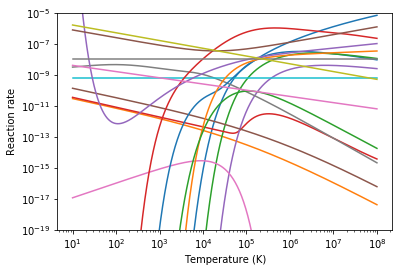

In [26]:
T = np.logspace(1, 8, 1024)
for i, rxn in enumerate(all_reactions):
    plt.loglog(T, calc_rate(T, i + 1), label='k%d' % (i + 1))
# plt.legend()
plt.ylim([1e-19, 1e-5])
plt.xlabel('Temperature (K)')
plt.ylabel('Reaction rate')

In [65]:
composition = {species: 1. for species in all_species}
comp_hist = [composition]

In [27]:
def calc_change(t, reactions, temp):
    # Calculate rates
    swap_dict = {}
    for i, k in range(ks):
        swap_dict[k] = calc_rate(1e5, i + 1)
    for species in all_species:
        swap_dict[species] = comp_hist[-1][species]
    new_composition = {}
    for species in all_species:
        rhs = all_rhs[species]
        delta = rhs.subs(swap_dict)
        new_composition[species] = comp_hist[-1][species] + delta
    